Epoch 1/10, Loss: 56.16626498209635
Epoch 2/10, Loss: 52.440428540039065
Epoch 3/10, Loss: 46.229499287923176
Epoch 4/10, Loss: 42.299945857747396
Epoch 5/10, Loss: 41.084616475423175
Epoch 6/10, Loss: 40.28077963053386
Epoch 7/10, Loss: 39.73331717529297
Epoch 8/10, Loss: 39.42073703613281
Epoch 9/10, Loss: 39.14385254313151
Epoch 10/10, Loss: 38.915651953125


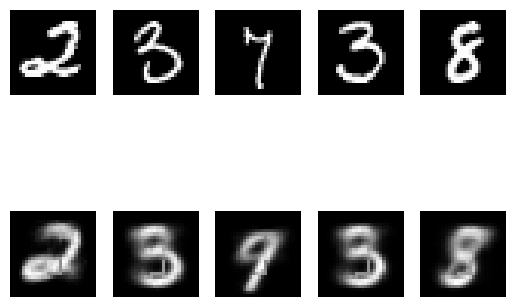

In [ ]:
#Q1
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
latent_dim = 2  # Dimensionality of the latent space
epochs = 10
learning_rate = 1e-3

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, latent_dim)  # Mean of the latent space
        self.fc3 = nn.Linear(128, latent_dim)  # Log variance of the latent space

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        mean = self.fc2(x)
        log_var = self.fc3(x)
        return mean, log_var

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        z = z.view(z.size(0), 64, 7, 7)
        z = torch.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, log_var

# Loss function
def vae_loss(x, x_reconstructed, mean, log_var):
    # Reconstruction loss (MSE)
    reconstruction_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + kl_loss

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstructed, mean, log_var = vae(data)
        loss = vae_loss(data, x_reconstructed, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader.dataset)}')

# Testing and visualizing results
vae.eval()
with torch.no_grad():
    data, _ = next(iter(train_loader))
    data = data.to(device)
    x_reconstructed, _, _ = vae(data)
    x_reconstructed = x_reconstructed.cpu()

    # Display original and reconstructed images
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(data[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(x_reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()


Files already downloaded and verified


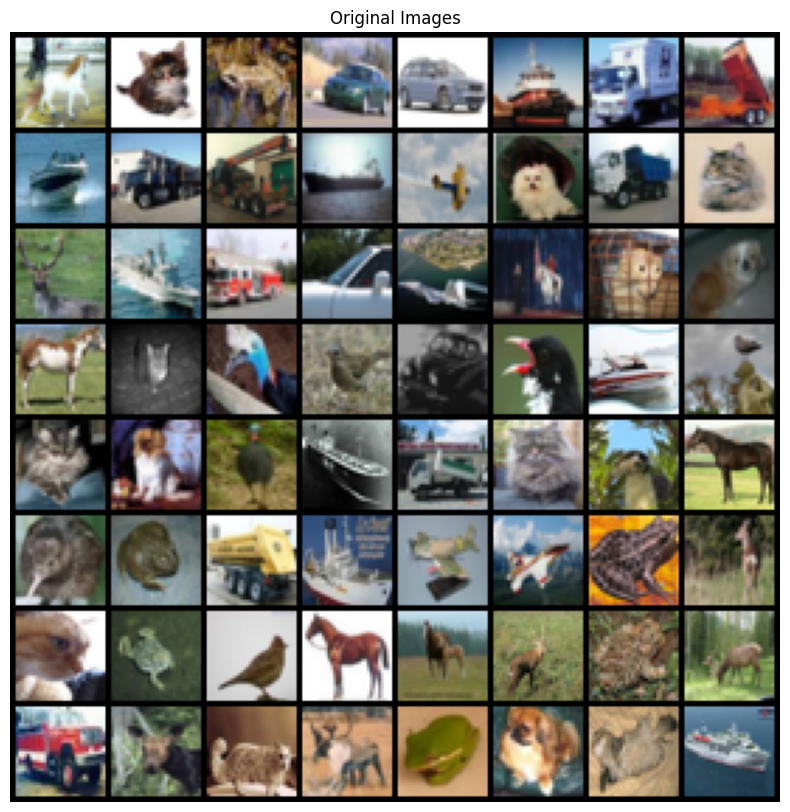

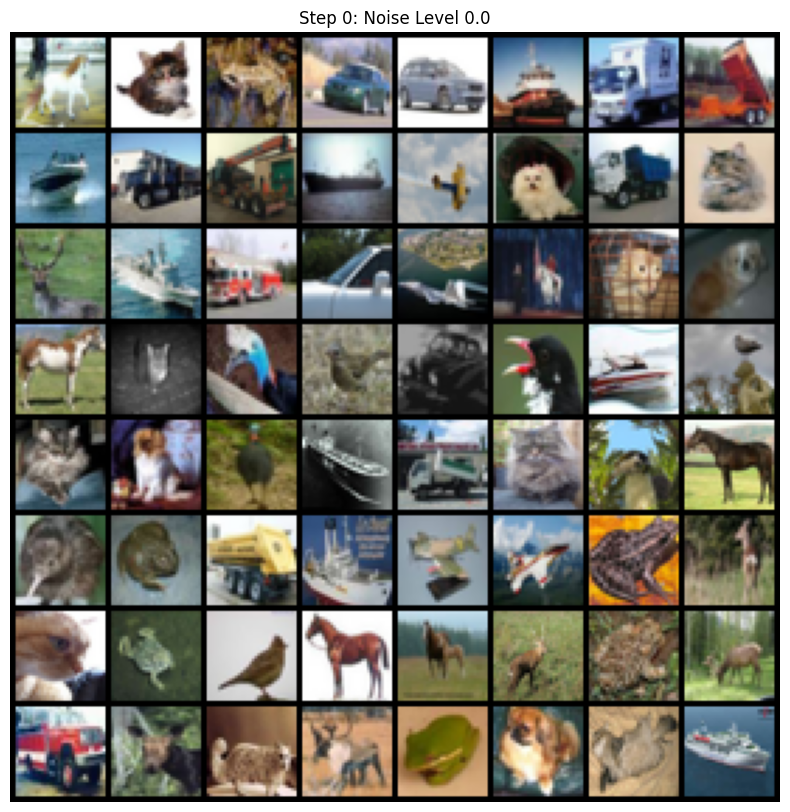

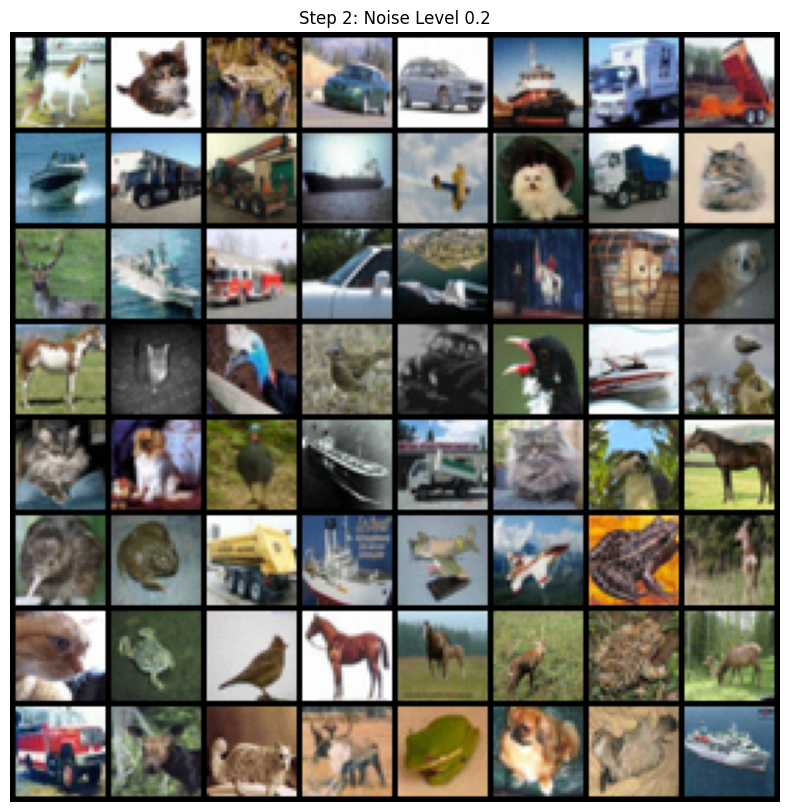

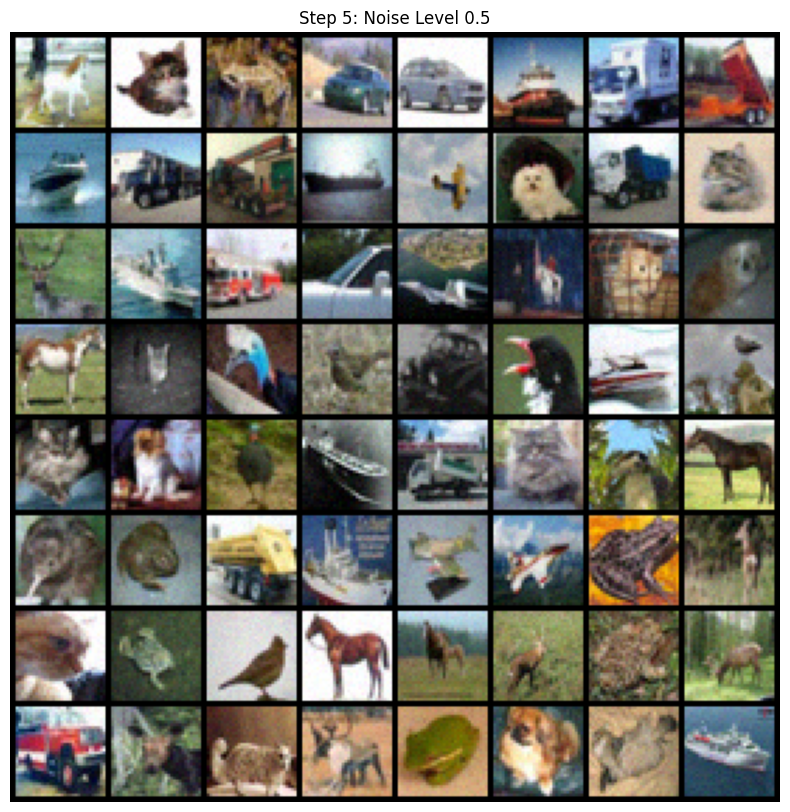

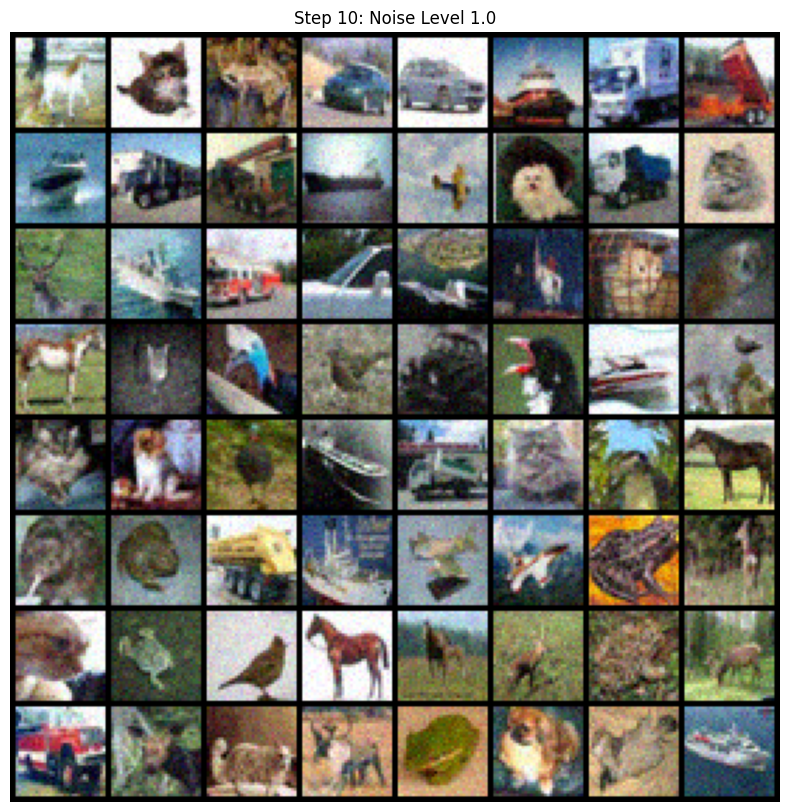

Epoch [1/5], Loss: 12.4030
Epoch [2/5], Loss: 4.7114
Epoch [3/5], Loss: 4.1150
Epoch [4/5], Loss: 3.7868
Epoch [5/5], Loss: 3.5876


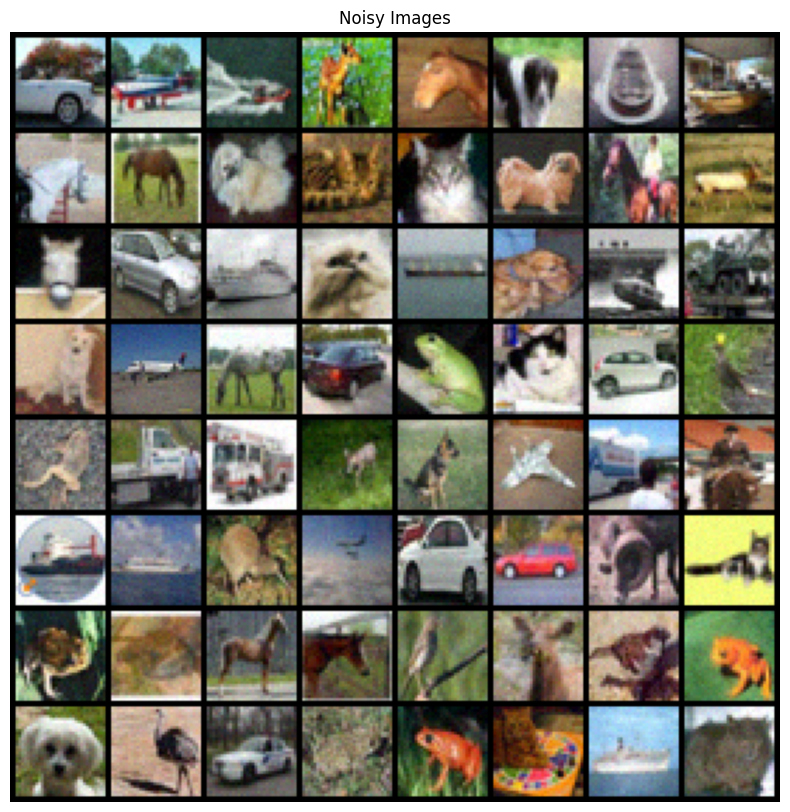

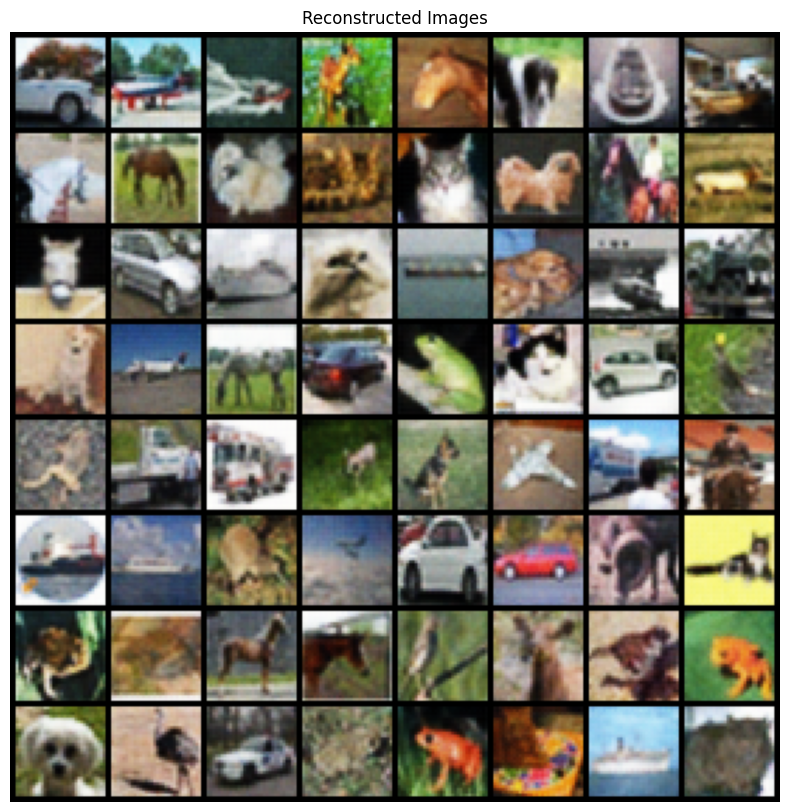

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Initial setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Function to display images
def show_images(images, title=""):
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

# Add Gaussian noise to images
def add_noise(images, t, noise_strength=0.1):
    noise = torch.randn_like(images) * noise_strength * (t / 10)
    noisy_images = images + noise
    return torch.clip(noisy_images, -1, 1)

# Display original images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images, title="Original Images")

# Visualize noisy images at different steps
for t in [0, 2, 5, 10]:
    noisy_images = add_noise(images, t)
    show_images(noisy_images, title=f"Step {t}: Noise Level {t/10}")

# Design the U-Net neural network model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + num_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x, condition):
        # Convert condition to one-hot
        batch_size = x.shape[0]
        num_classes = 10  # Number of classes
        one_hot_condition = torch.zeros((batch_size, num_classes), device=x.device)
        one_hot_condition[torch.arange(batch_size), condition] = 1

        # Expand dimensions to match input
        one_hot_condition = one_hot_condition.unsqueeze(-1).unsqueeze(-1)
        one_hot_condition = one_hot_condition.repeat(1, 1, x.shape[-2], x.shape[-1])

        # Combine with input
        x = torch.cat((x, one_hot_condition), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Function to train the model
def train_model(model, dataloader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Add noise to images
            noisy_images = add_noise(images, t=5)

            # Reconstruct images
            outputs = model(noisy_images, labels)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Example usage of the model
unet_model = UNet(num_classes=10).to(device)
train_model(unet_model, trainloader, num_epochs=5)

# Test the reconstruction of images
def test_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            noisy_images = add_noise(images, t=5)
            outputs = model(noisy_images, labels)
            show_images(noisy_images, title="Noisy Images")
            show_images(outputs, title="Reconstructed Images")
            break

test_model(unet_model, trainloader)
